In [21]:
# Created by Matt Davison 15/01/2026
# Tests the total harmonic distortion and signal-to-noise ratio of the HaptiCoupler system, communicating with it via USB Serial.

import serial
import numpy as np
import sounddevice as sd
import scipy.signal as signal
import time
import matplotlib.pyplot as plt
import scienceplots

sampling_rate = 44100
record_time_s = 10
buffer_time_s = 1
test_freq_hz = 100
usb_serial_name = '/dev/tty.usbmodem167058301'

#Maximum output of device with 9V PSU is 4.21Vrms = 12.5dBV
dbv_offset = 12.5
signal_levels_dbv = [-30.0, -20.0, -10.0, 0.0, 10.0]
num_levels = len(signal_levels_dbv)


In [24]:
def generate_sine_wave(frequency_hz, sample_rate_hz, duration_sec, amplitude=1.0, phase=0.0):
    t = np.arange(0, duration_sec, 1.0 / sample_rate_hz)
    samples = amplitude * np.sin(2 * np.pi * frequency_hz * t + phase)
    return samples


def measure_system_response(fs, stimulus_signal, input_gain=0.1):
    
    stimulus_signal = stimulus_signal * input_gain

    print("Playing and recording")
    recording = sd.playrec(stimulus_signal, samplerate=fs, channels=2, dtype='float64')
    sd.wait()
    print("Done recording")

    return recording[:, 0], recording[:, 1] # current, voltage


#Open USB serial connection to HaptiCoupler
ser = serial.Serial(usb_serial_name)
print(ser.name) #Print the name of the opened serial port

#Set LPFs to cut off at 20kHz
ser.write(b'lpi 20000\n')
ser.write(b'lpo 20000\n')

#Set actuation output level to 0dBFS
ser.write(b'al -0.0\n')

#Ensure that the HaptiCoupler is in Debug mode (raw current values returned)
ser.write(b'debug\n')

stimulus = generate_sine_wave(test_freq_hz, sampling_rate, record_time_s)

print(sd.query_devices())

measured_current, measured_voltage = measure_system_response(sampling_rate, stimulus, 1.0)
measured_current_buffered = (measured_current[(buffer_time_s*sampling_rate):(record_time_s-buffer_time_s*sampling_rate)]) * 3
measured_voltage_buffered = measured_voltage[(buffer_time_s*sampling_rate):(record_time_s-buffer_time_s*sampling_rate)] * 11

v_pk2pk = (np.max(measured_voltage_buffered) - np.min(measured_voltage_buffered))

v_rms = np.sqrt(np.mean((measured_voltage_buffered)**2))
i_rms = np.sqrt(np.mean((measured_current_buffered)**2))
print("Voltage RMS: {}V, Voltage peak to peak: {}V, Current RMS {}mA".format(v_rms, v_pk2pk, i_rms*1000))


measured_current_buffered.tofile('outputs/snr_thd_sine.csv', sep = ',')

/dev/tty.usbmodem167058301
>  0 Teensy MIDI_Audio, Core Audio (2 in, 0 out)
<  1 Teensy MIDI_Audio, Core Audio (0 in, 2 out)
   2 MacBook Pro Microphone, Core Audio (1 in, 0 out)
   3 MacBook Pro Speakers, Core Audio (0 in, 2 out)
   4 Microsoft Teams Audio, Core Audio (1 in, 1 out)
   5 ZoomAudioDevice, Core Audio (2 in, 2 out)
   6 Teensy & HP, Core Audio (0 in, 0 out)
   7 Aggregate Device, Core Audio (0 in, 0 out)
   8 Teensy and Speakers, Core Audio (0 in, 2 out)
   9 teensy io combined, Core Audio (0 in, 0 out)
  10 HaptiCoupler n Speakers, Core Audio (2 in, 4 out)
Playing and recording
Done recording
Voltage RMS: 4.208409475338109V, Voltage peak to peak: 11.915771484375V, Current RMS 358.3003550156756mA


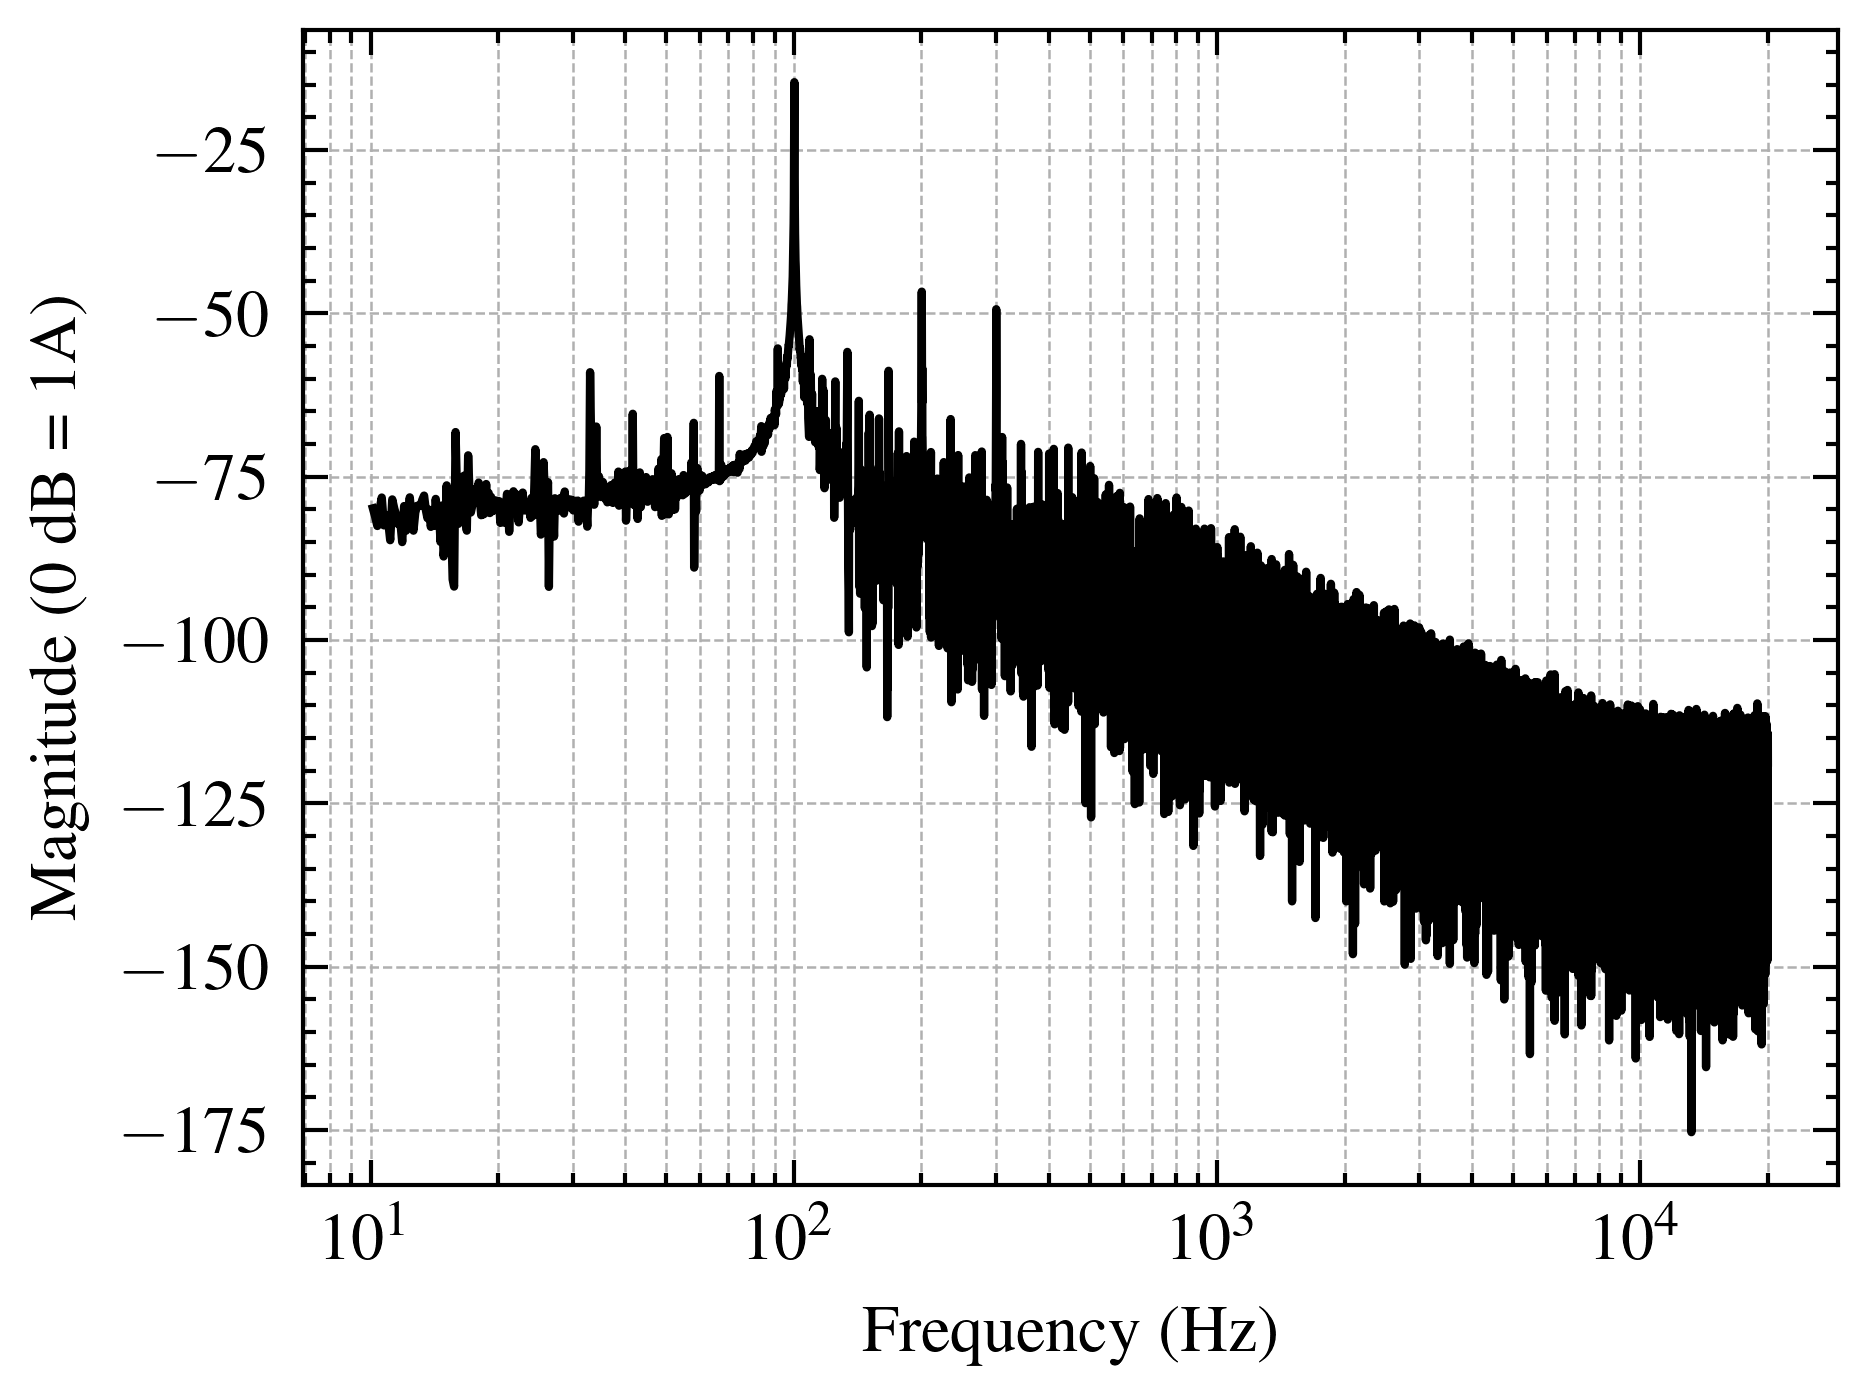

In [25]:
def calc_FFT(signal):
    X = np.fft.rfft(signal)
    freq = np.fft.rfftfreq(len(signal), 1/sampling_rate)
    return X, freq

def smooth_magnitude(freqs, magnitude, smoothing_octaves=0.2):
    smoothed = np.zeros_like(magnitude)
    for i, f in enumerate(freqs):
        if f <= 0:
            smoothed[i] = magnitude[i]
            continue
        f_low = f * 2**(-smoothing_octaves / 2)
        f_high = f * 2**(smoothing_octaves / 2)
        mask = (freqs >= f_low) & (freqs <= f_high)
        smoothed[i] = np.mean(magnitude[mask])
    return smoothed




sig_fft, freqs = calc_FFT(measured_current_buffered)
#sig_fft = smooth_magnitude(freqs, np.abs(sig_fft), 0.005)

freq_min_hz = 10
freq_max_hz = 20000
valid = (freqs >= freq_min_hz) & (freqs <= freq_max_hz)
freqs = freqs[valid]
sig_fft = sig_fft[valid]
sig_fft = sig_fft / len(measured_current)
fft_db = 20*np.log10(abs(sig_fft))
fft_db_normalised = fft_db #- np.max(fft_db)

fig, ax = plt.subplots()
ax.semilogx(freqs, fft_db_normalised)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Magnitude (0 dB = 1A)")

plt.grid(True, which='both',axis='x', linestyle='--', linewidth=0.3)
plt.grid(True, which='major',axis='y', linestyle='--', linewidth=0.3)

plt.style.use(['science', 'ieee'])
plt.savefig('outputs/thd_snr_fft.eps', format='eps')
plt.show()

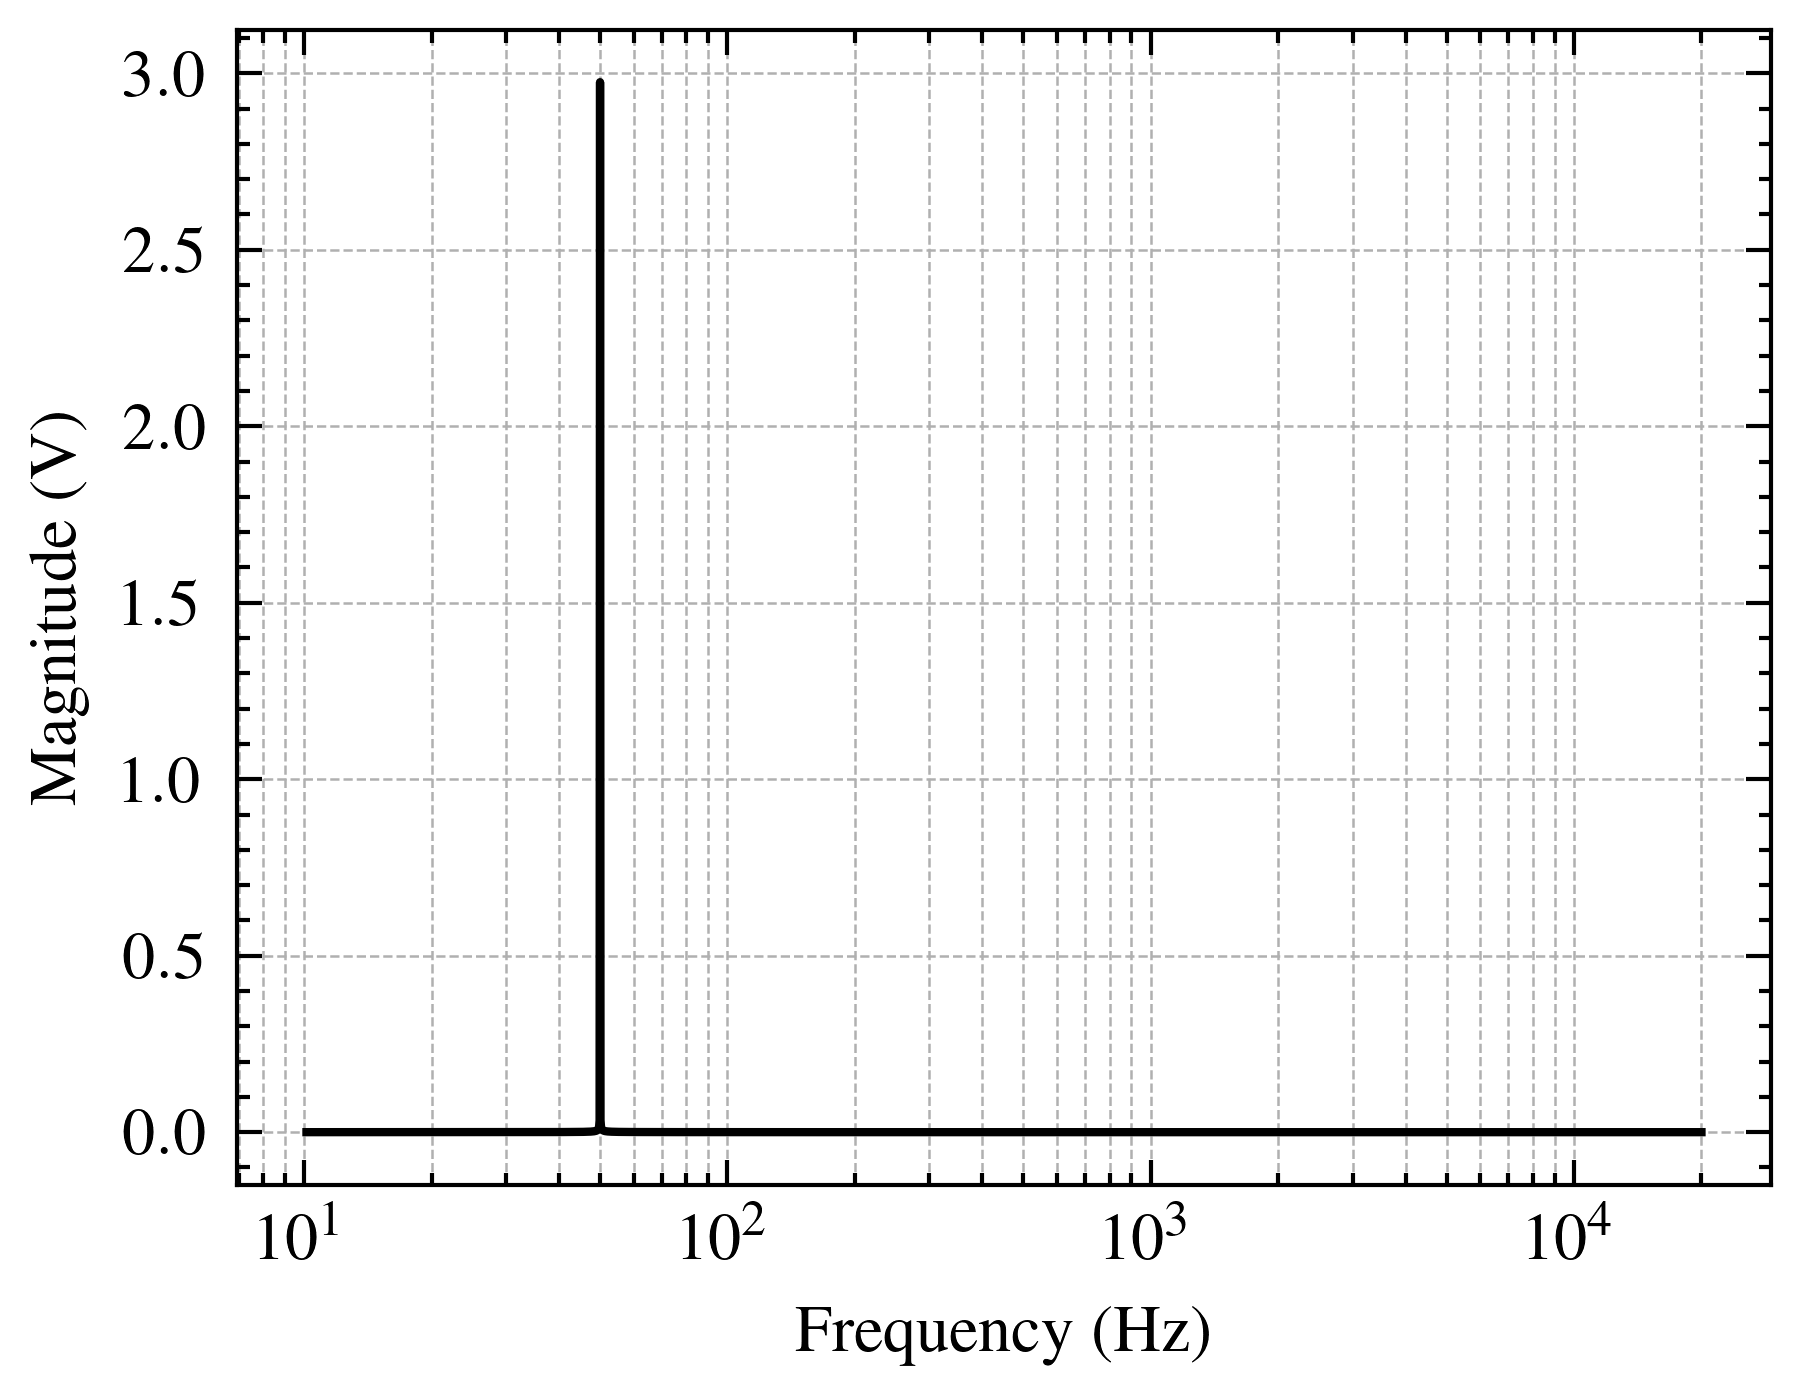

In [48]:
voltage_fft, freqs = calc_FFT(measured_voltage_buffered * 11)
#sig_fft = smooth_magnitude(freqs, np.abs(sig_fft), 0.005)

freq_min_hz = 10
freq_max_hz = 20000
fft_len = len(voltage_fft)
valid = (freqs >= freq_min_hz) & (freqs <= freq_max_hz)
freqs = freqs[valid]
voltage_fft = voltage_fft[valid]
fft_db = 20*np.log10(abs(voltage_fft))
fft_db_normalised = fft_db - np.max(fft_db)

voltage_fft = abs(voltage_fft / fft_len)

fig, ax = plt.subplots()
ax.semilogx(freqs, voltage_fft)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Magnitude (V)")

plt.grid(True, which='both',axis='x', linestyle='--', linewidth=0.3)
plt.grid(True, which='major',axis='y', linestyle='--', linewidth=0.3)

plt.style.use(['science', 'ieee'])
plt.savefig('outputs/thd_snr_voltage_fft.eps', format='eps')
plt.show()

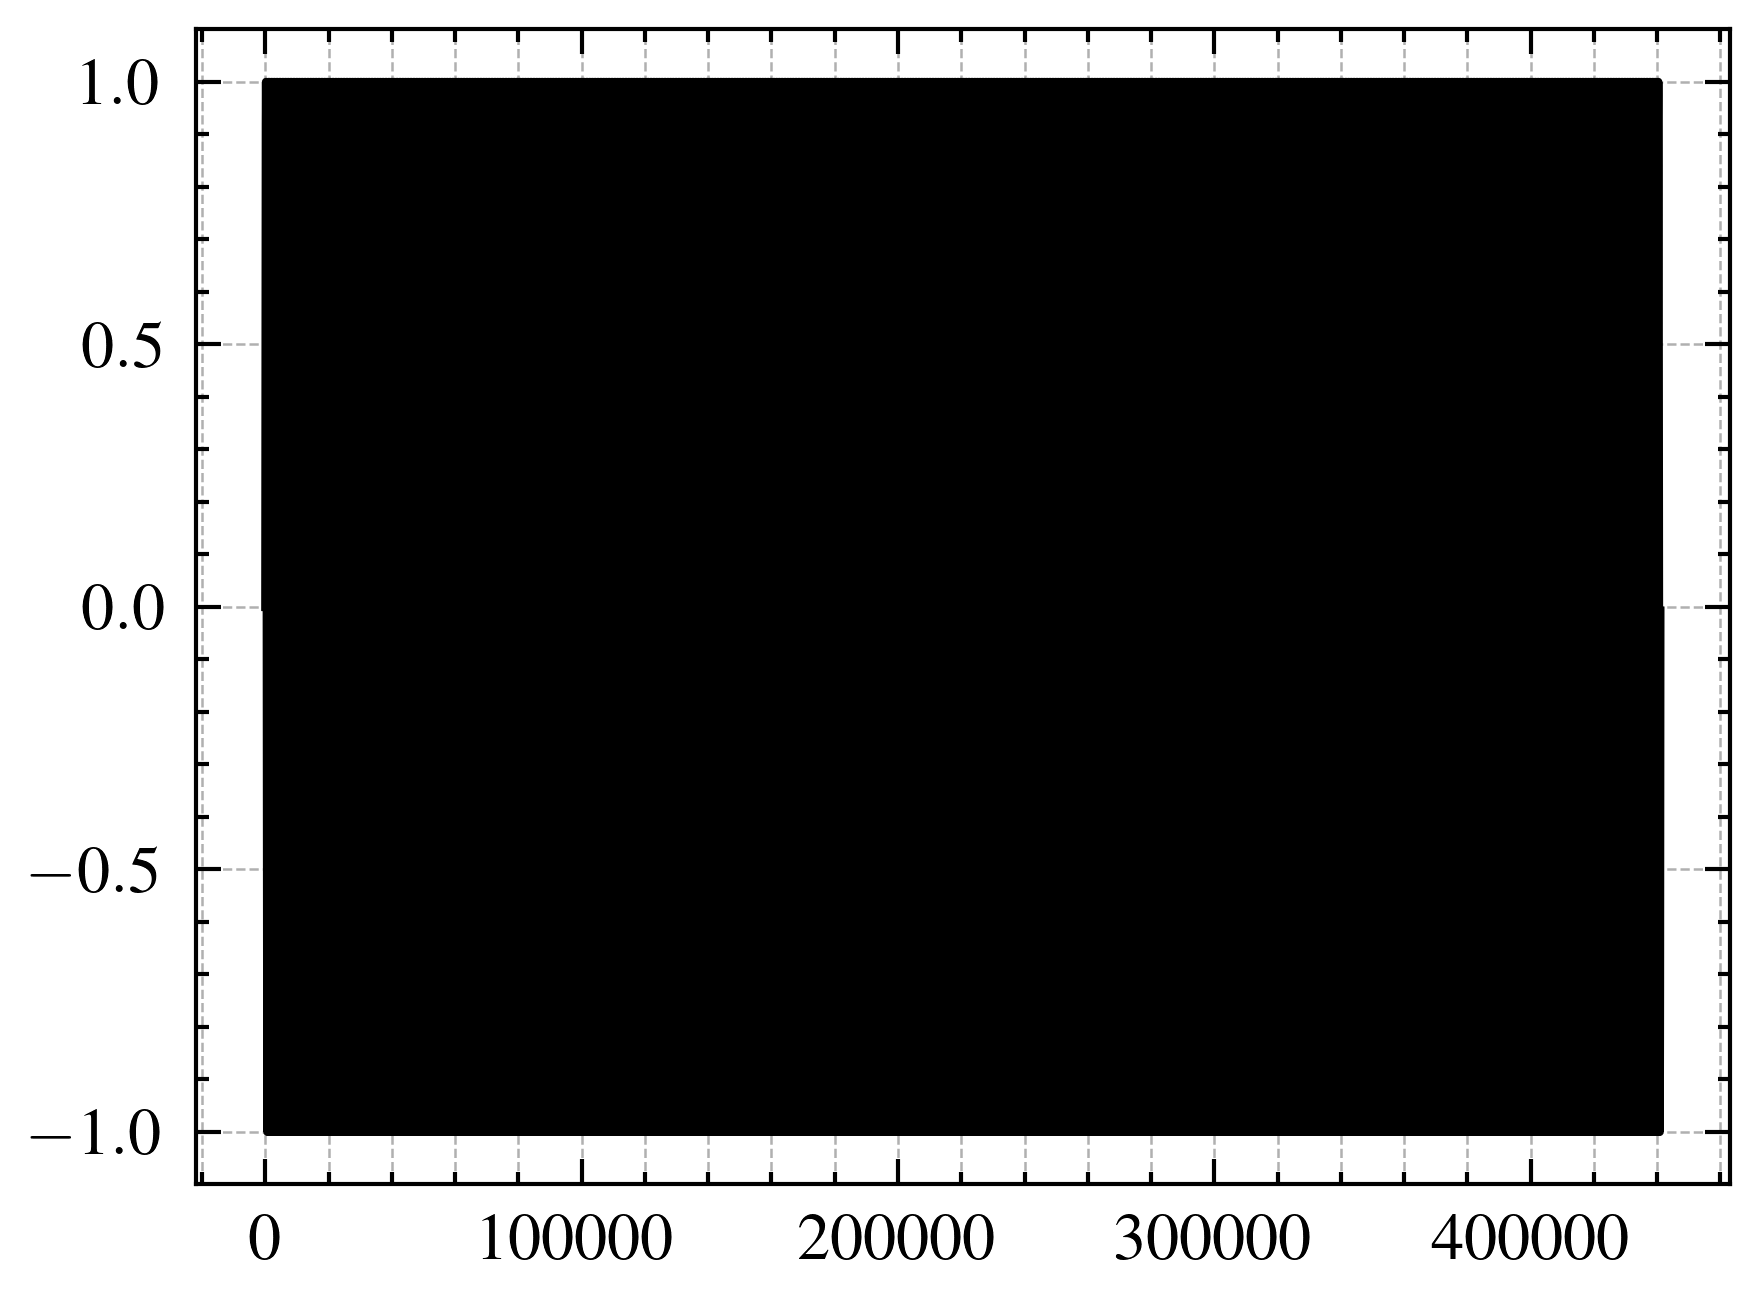

In [41]:
fig, ax = plt.subplots()
ax.plot(stimulus)

plt.grid(True, which='both',axis='x', linestyle='--', linewidth=0.3)
plt.grid(True, which='major',axis='y', linestyle='--', linewidth=0.3)

plt.style.use(['science', 'ieee'])
plt.show()